# Portfolio Optimization Model

Done by Joel Kambey

 ### Objective
 
 To construct a portfolio based form different allocation strategies (example: by maximizing Sharpe Ratio or minimizing standard deviation/risk).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Set the required functions (e.g. plotting the Efficient Frontier, Allocations, etc) and import the required libraries.

In [2]:
import pandas as pd
import numpy as np

def get_ind_returns():
    """
    Load and format 30 Industry Portfolios Value Weighted Monthly Returns
    """
    ind = pd.read_csv("data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend)
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
    return ax

def optimal_weights(n_points, er, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

from scipy.optimize import minimize
def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that minimize volatility
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

def msr(riskfree_rate, er, cov):
    """
    Return the weights of the Maximum Sharpe Ratio portfolio
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def gmv(cov):
    """
    Return the weights of the Global Minimum Volatility portfolio
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the volatility of a portfolio
    """
    return (weights.T @ covmat @ weights)**0.5

### Data Processing

Lets use the returns data from the most recent 6-year window (from 2010 to 2016).

In [3]:
ind = get_ind_returns()
er = annualize_rets(ind["2010":"2016"], 12)
cov = ind["2010":"2016"].cov()

For this practice, the free dataset contains monthly return data from 30 different industries from 1926 to 2017.

In [4]:
# set to display all columns in the dataframe
pd.set_option('display.max_columns', None)

# check the first 10 rows of the dataset
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,Cnstr,Steel,FabPr,ElcEq,Autos,Carry,Mines,Coal,Oil,Util,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,0.0207,0.0407,0.0543,0.0318,0.1639,0.0102,0.0564,0.0154,-0.0140,0.0704,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,0.0472,0.0217,0.0206,0.0210,0.0423,0.0166,0.0055,0.0085,0.0369,-0.0169,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,-0.0050,0.0015,0.0036,-0.0056,0.0483,0.0273,0.0174,0.0030,-0.0369,0.0204,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,-0.0455,-0.0385,0.0111,-0.0573,-0.0793,-0.0556,-0.0320,0.0223,-0.0104,-0.0263,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,0.0220,0.0386,0.0318,0.0508,-0.0066,0.0787,0.0846,-0.0048,0.0006,0.0371,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


In [5]:
# check for null dataset
ind.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1110 entries, 1926-07 to 2018-12
Freq: M
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    1110 non-null   float64
 1   Beer    1110 non-null   float64
 2   Smoke   1110 non-null   float64
 3   Games   1110 non-null   float64
 4   Books   1110 non-null   float64
 5   Hshld   1110 non-null   float64
 6   Clths   1110 non-null   float64
 7   Hlth    1110 non-null   float64
 8   Chems   1110 non-null   float64
 9   Txtls   1110 non-null   float64
 10  Cnstr   1110 non-null   float64
 11  Steel   1110 non-null   float64
 12  FabPr   1110 non-null   float64
 13  ElcEq   1110 non-null   float64
 14  Autos   1110 non-null   float64
 15  Carry   1110 non-null   float64
 16  Mines   1110 non-null   float64
 17  Coal    1110 non-null   float64
 18  Oil     1110 non-null   float64
 19  Util    1110 non-null   float64
 20  Telcm   1110 non-null   float64
 21  Servs   1110 non-nu

### Building the Model

Initialize and plot the Efficient Frontier.

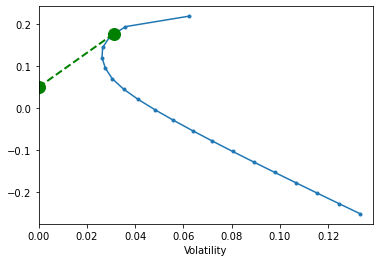

In [6]:
# plot EF
ax = plot_ef(20, er, cov)
ax.set_xlim(left = 0)

# Set Risk-Free Rate
rf = 0.05

# get MSR weights, return, and volatility
w_msr = msr(rf, er, cov)
r_msr = portfolio_return(w_msr, er)
vol_msr = portfolio_vol(w_msr, cov)

# get GMV weights, return, and volatility
w_gmv = gmv(cov)
r_gmv = portfolio_return(w_gmv, er)
vol_gmv = portfolio_vol(w_gmv, cov)

# add CML to the plot
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

### Portfolio Allocations

1. Maximum Sharpe Ratio

In [7]:
industries = list(ind.columns.values)
msr_portfolio = np.round(w_msr, 3)*100

for i in range(len(msr_portfolio)):
    if msr_portfolio[i] != 0:
        print (f'{industries[i]}: {round(msr_portfolio[i], 3)}%')

Beer: 22.0%
Smoke: 26.1%
Txtls: 2.0%
Meals: 50.0%


2. Global Minimum Variance

In [8]:
gmv_portfolio = np.round(w_gmv, 3)*100

for i in range(len(gmv_portfolio)):
    if gmv_portfolio[i] != 0:
        print (f'{industries[i]}: {round(gmv_portfolio[i], 3)}%')

Food: 2.8%
Beer: 24.1%
Hshld: 22.9%
Hlth: 1.3%
Util: 27.0%
Meals: 21.9%


### Backtesting

Compare both portfolios performance when for example holding them for the first two months in 2017

In [9]:
er_test = annualize_rets(ind['201701':'201702'], 12)
cov_test =  cov = ind['201701':'201702'].cov()

r_test_msr = portfolio_return(w_msr, er_test)
vol_test_msr = portfolio_vol(w_msr, cov_test)

print (f'MSR Portfolio Return: {round(r_test_msr,2)}')
print (f'MSR Portfolio Volatility: {round(vol_test_msr,3)}')

MSR Portfolio Return: 0.51
MSR Portfolio Volatility: 0.021


In [10]:
r_test_gmv = portfolio_return(w_gmv, er_test)
vol_test_gmv = portfolio_vol(w_gmv, cov_test)

print (f'GMV Portfolio Return: {round(r_test_gmv,2)}')
print (f'GMV Portfolio Volatility: {round(vol_test_gmv,3)}')

GMV Portfolio Return: 0.37
GMV Portfolio Volatility: 0.024


MSR Portfolio has the best performance for the first two months of 2017.